# Import lib and Load Data

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import io


In [ ]:
df1=pd.read_csv("geoplaces2.csv")
df2=pd.read_csv("rating_final.csv")
ratings=pd.merge(df1,df2) # merge two df's
ratings=ratings[['placeID','name','userID','rating']] # take needed columns
ratings['userID'] = ratings['userID'].str[1:] 
ratings.dropna(inplace=True) 
ratings.head() # show new dataframe

<ipython-input-36-dbaa792ba799>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['userID'] = ratings['userID'].str[1:]
<ipython-input-36-dbaa792ba799>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings.dropna(inplace=True)


,placeID,name,userID,rating
0,134999,Kiku Cuernavaca,1093,2
1,134999,Kiku Cuernavaca,1066,1
2,134999,Kiku Cuernavaca,1040,1
3,134999,Kiku Cuernavaca,1110,2
4,134999,Kiku Cuernavaca,1121,2


# Data Analysis

In [ ]:
ratings.info() # infos about samples, features and datatypes
print('Shape of Data :')
ratings.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1161 entries, 0 to 1160
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   placeID  1161 non-null   int64 
 1   name     1161 non-null   object
 2   userID   1161 non-null   object
 3   rating   1161 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 45.4+ KB
Shape of Data :


(1161, 4)

In [ ]:
ratings.name.nunique() # unique number of restaurants

129

# Data Visualization

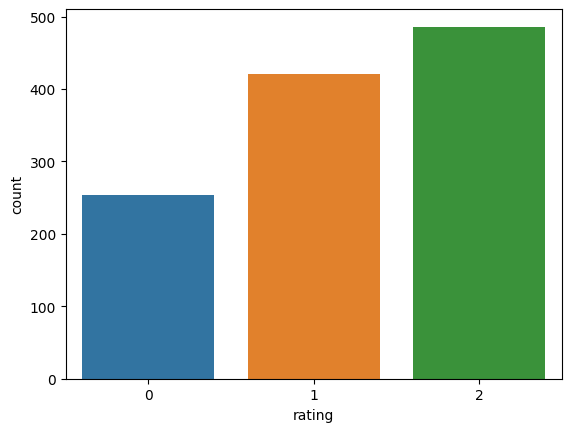

In [ ]:
sns.countplot(x=ratings.rating); # plot the ratings

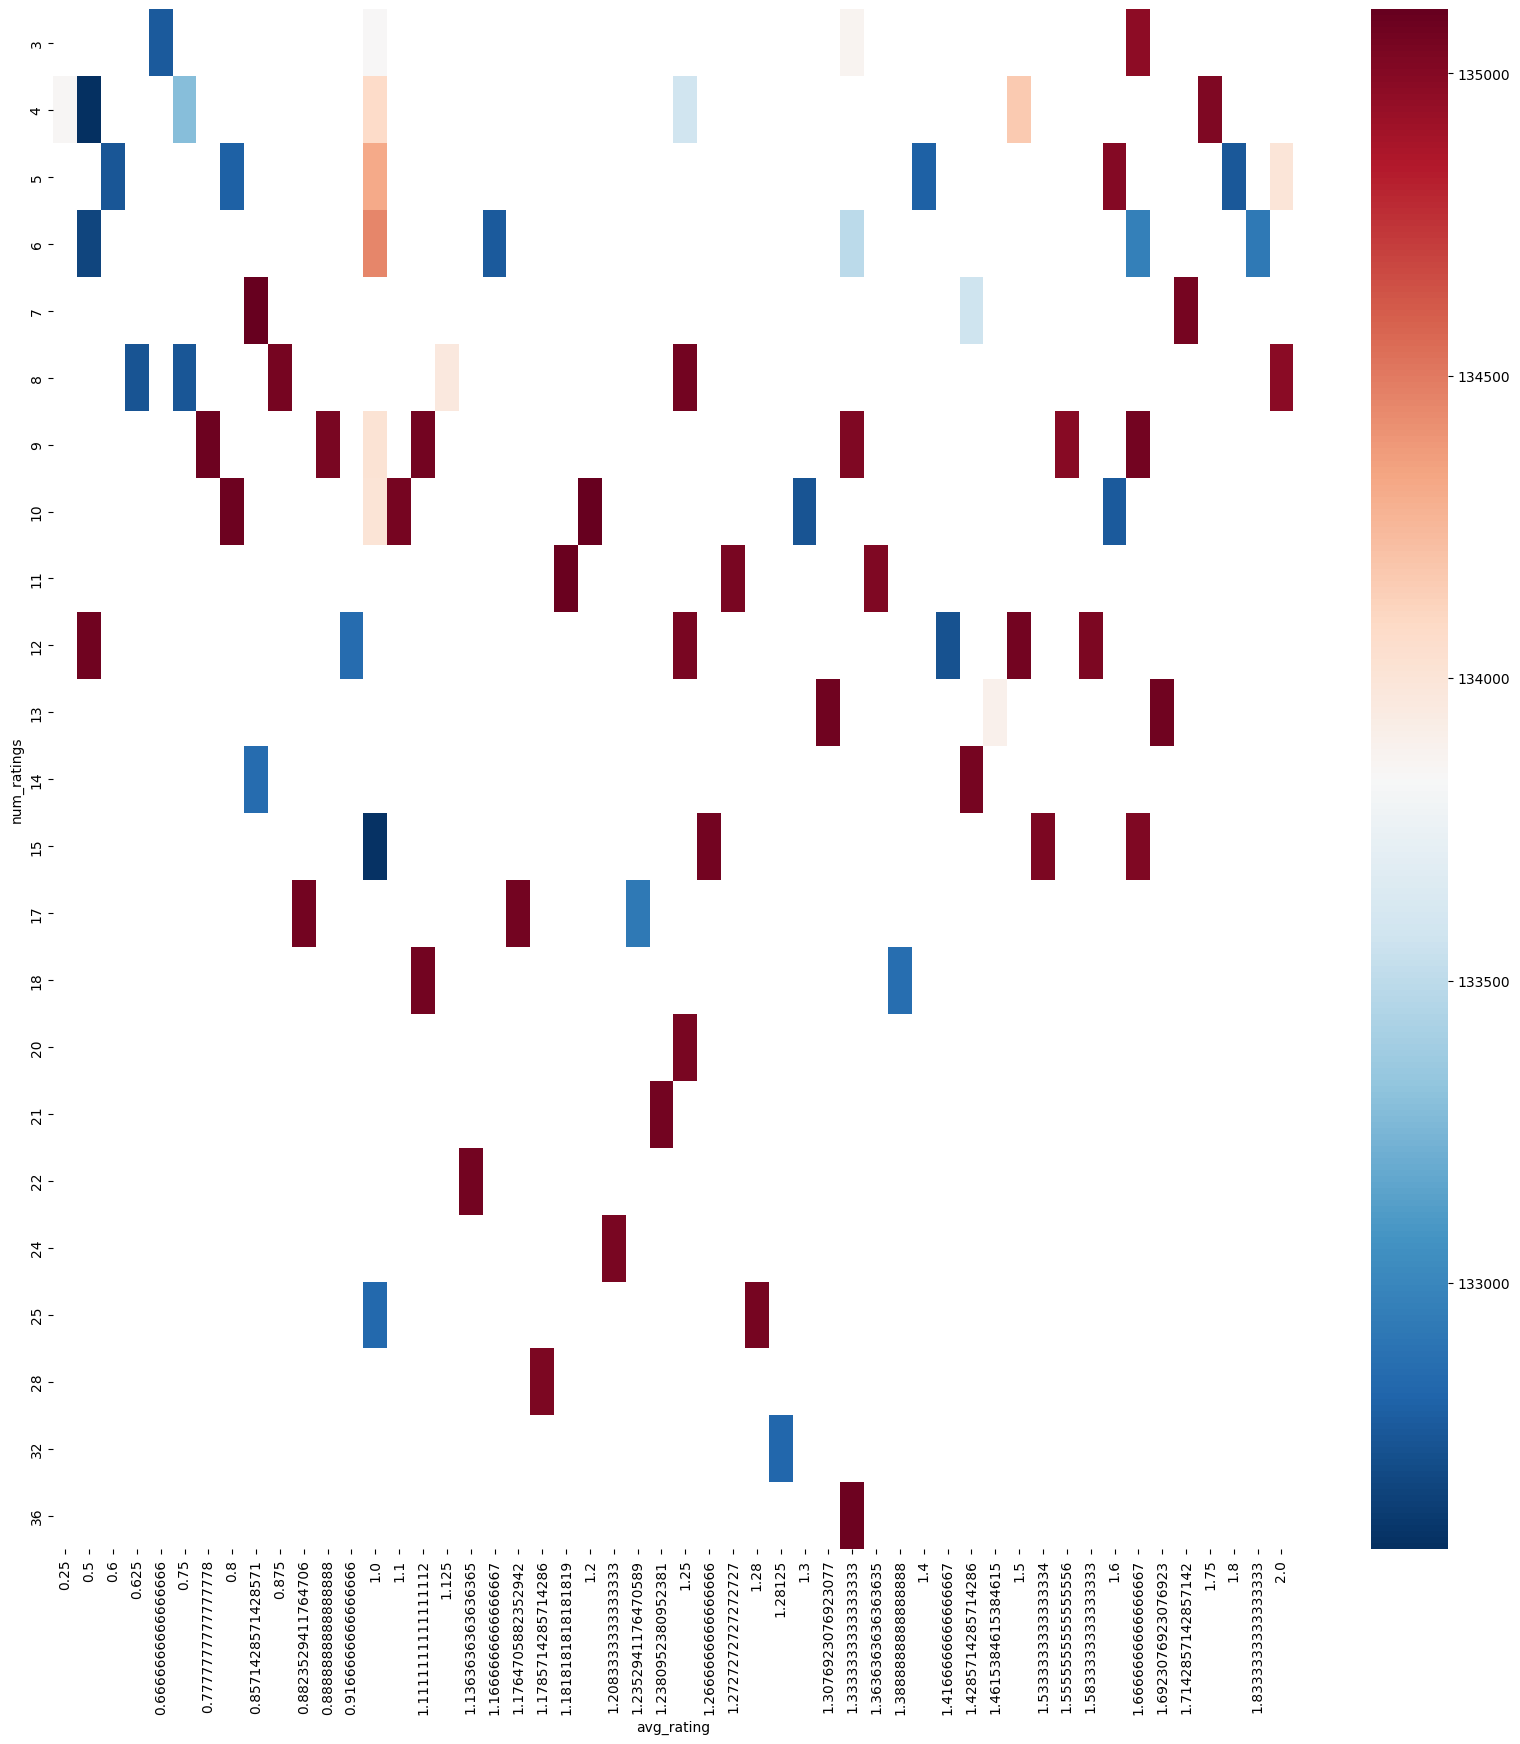

In [ ]:
# Group the data by item ID and calculate the number of ratings and average rating for each item
item_ratings = ratings.groupby('placeID').agg({'rating': ['count', 'mean']}).reset_index()
# Rename the columns
item_ratings.columns = ['placeID', 'num_ratings', 'avg_rating']
# Create a pivot table showing the correlation between the number of ratings and average rating for each book
pivot = pd.pivot_table(item_ratings, index='num_ratings', columns='avg_rating', values='placeID')
# Create a heatmap of the pivot table
plt.figure(figsize=(20,20))
sns.heatmap(pivot, cmap='RdBu_r');

# Popular Restaurants 
### using popularity based recommender system (not based on ratings)

In [ ]:
# function to calculate popularity stats
def popularity_based_rec(df, group_col, rating_col):
    # group by title and get size, sum and mean values
    grouped = df.groupby(group_col).agg({rating_col: [np.size, np.sum, np.mean]})
    # most popular mean value on top
    popular = grouped.sort_values((rating_col, "sum"), ascending=False)
    return popular

In [ ]:
# call function and show top 5 restaurants
popularity_stats = popularity_based_rec(ratings, "name", "rating")
popularity_stats.head(10) # show top 5 restaurants

rating              
                                     size sum      mean
name                                                   
Tortas Locas Hipocampo                 36  48  1.333333
puesto de tacos                        32  41  1.281250
Cafeteria y Restaurant El Pacifico     28  33  1.178571
La Cantina Restaurante                 25  32  1.280000
Restaurant la Chalita                  24  29  1.208333
Restaurante El Cielo Potosino          21  26  1.238095
Restaurant Oriental Express            20  25  1.250000
Gorditas Doa Gloria                    25  25  1.000000
La Posada del Virrey                   18  25  1.388889
El Rincon de San Francisco             15  25  1.666667

# K-Nearest Neighbor based recommender system

In [ ]:
#sort the restaurants from largest to smallest according to its mean ratings
itemProperties = ratings.groupby("placeID").agg({"rating": [np.size, np.mean]})
itemProperties.head()

rating      
          size  mean
placeID             
132560       4  0.50
132561       4  0.75
132564       4  1.25
132572      15  1.00
132583       4  1.00

In [ ]:
# calculate their percentages
itemNumRatings = pd.DataFrame(itemProperties["rating"]["size"])
itemNormalizedNumRatings = itemNumRatings.apply(lambda x: (x-np.min(x)) / (np.max(x) - np.min(x)))
itemNormalizedNumRatings.head() # show last 5 entries

,size
placeID,
132560,0.030303
132561,0.030303
132564,0.030303
132572,0.363636
132583,0.030303


In [ ]:
ratings.to_csv("ratings.csv")

In [ ]:
df=pd.read_csv('ratings.csv')
df.head()

,Unnamed: 0,placeID,name,userID,rating
0,0,134999,Kiku Cuernavaca,1093,2
1,1,134999,Kiku Cuernavaca,1066,1
2,2,134999,Kiku Cuernavaca,1040,1
3,3,134999,Kiku Cuernavaca,1110,2
4,4,134999,Kiku Cuernavaca,1121,2


In [ ]:
# store all restaurants in a dictionary with their id's, names ratings, number of ratings and average ratings
itemDict = {} # create an empty item Dictionary
# Read in the ratings data from the CSV file
with open('ratings.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)  # skip the first row
    for row in csv_reader:
        if row[1] == '' or row[2] == '' or row[3] == '' or row[4] == '': #skip empty rows
            continue
        # get the right columns
        itemID = int(row[1])
        name = row[2]
        userID = int(row[3])
        rating = int(row[4])

        if itemID not in itemDict:
            itemDict[itemID] = {'name': name, 'ratings': [], 'numRatings': 0, 'totalRating': 0}
        itemDict[itemID]['ratings'].append(rating)
        itemDict[itemID]['numRatings'] += 1
        itemDict[itemID]['totalRating'] += rating

# Calculate the average rating for each item
for itemID in itemDict:
    item = itemDict[itemID]
    name = item['name']
    ratings = item['ratings']
    numRatings = item['numRatings']
    totalRating = item['totalRating']
    avgRating = totalRating / numRatings
    itemDict[itemID] = {'name': name, 'ratings': ratings, 'numRatings': numRatings, 'avgRating': avgRating}

In [ ]:
itemDict

{134999: {'name': 'Kiku Cuernavaca',
  'ratings': [2, 1, 1, 2, 2],
  'numRatings': 5,
  'avgRating': 1.6},
 132825: {'name': 'puesto de tacos',
  'ratings': [2,
   2,
   1,
   1,
   2,
   2,
   1,
   2,
   1,
   2,
   2,
   2,
   0,
   1,
   2,
   1,
   0,
   0,
   2,
   2,
   1,
   2,
   0,
   1,
   2,
   0,
   1,
   1,
   0,
   2,
   1,
   2],
  'numRatings': 32,
  'avgRating': 1.28125},
 135106: {'name': 'El Rinc�n de San Francisco',
  'ratings': [2, 2, 1, 2, 0, 2, 0, 0, 2, 1],
  'numRatings': 10,
  'avgRating': 1.2},
 132667: {'name': 'little pizza Emilio Portes Gil',
  'ratings': [1, 1, 1, 2],
  'numRatings': 4,
  'avgRating': 1.25},
 132613: {'name': 'carnitas_mata',
  'ratings': [2, 1, 0, 1, 2, 1],
  'numRatings': 6,
  'avgRating': 1.1666666666666667},
 135040: {'name': 'Restaurant los Compadres',
  'ratings': [0, 0, 0, 1],
  'numRatings': 4,
  'avgRating': 0.25},
 132732: {'name': 'Taqueria EL amigo ',
  'ratings': [0, 1, 0, 0, 1, 0, 2, 1],
  'numRatings': 8,
  'avgRating': 0.6

In [ ]:
# function that finds the distance of an item from another item - SIMILARITY
def ComputeDistance(a, b):
    # Find the common ratings(by common user) for both item
    common_ratings = [rating for rating in a['ratings'] if rating in b['ratings']]

    # If there are no common ratings, the distance is infinity
    if len(common_ratings) == 0:
        return float('inf')

    # If the lists of ratings are not the same length, return infinity
    if len(a['ratings']) != len(b['ratings']):
        return float('inf')

    # Calculate the sum of the squared differences between the ratings
    sum_squared_differences = sum([(a['ratings'][i] - b['ratings'][i]) ** 2 for i in range(len(common_ratings))])

    # Return the square root of the sum of squared differences, which is the distance between the two items
    return sum_squared_differences ** 0.5

In [ ]:
# function to get K-Nearest Neighbors
def getNeighbors(itemID, K):
    # Get the item object for the given item ID
    target_item = itemDict[itemID]

    # Create a list of tuples (distance, itemID) for all items in the dictionary
    distances = [(ComputeDistance(target_item, itemDict[itemID]), itemID) for itemID in itemDict if itemDict[itemID]['name'] != target_item['name']]

    distances.sort()

    return distances[:K]

In [ ]:
# get the smallest distances as a list
neighbors = getNeighbors(134999, 30)
# Print the item names and distances of the nearest neighbors
for distance, itemID in neighbors:
    print(f"{itemDict[itemID]['name']}: {distance:.2f}")

el lechon potosino : 1.00
Chaires: 1.00
Pollo_Frito_Buenos_Aires: 1.41
Hamburguesas saul: 1.41
emilianos: 1.41
Michiko Restaurant Japones: 1.41
La Estrella de Dimas: 1.73
tacos de barbacoa enfrente del Tec: 2.00
Cenaduria El Rincón de Tlaquepaque: 2.00
Restaurant and Bar and Clothesline Carlos N Charlies: 2.24
Restaurante de Mariscos la Langosta: 2.24
Hamburguesas Valle Dorado: 2.45
carnitas mata calle Emilio Portes Gil: 2.65
Tortas y hamburguesas el gordo: 2.65
el pueblito: 2.65
TACOS CORRECAMINOS: 3.16
puesto de gorditas: inf
cafe ambar: inf
churchs: inf
Cafe Chaires: inf
McDonalds Centro: inf
Gorditas Dona Tota: inf
Hamburguesas La perica: inf
carnitas_mata: inf
la perica hamburguesa: inf
palomo tec: inf
Carnitas Mata  Calle 16 de Septiembre: inf
tacos abi: inf
little pizza Emilio Portes Gil: inf
TACOS EL GUERO: inf


# User based Recommender System

In [ ]:
ratings=pd.read_csv("ratings.csv")

In [ ]:
# Matrix Factorization (pivot_table)
userratings=ratings.pivot_table(index=['name'],columns=["userID"],values="rating")
userratings.tail(10)

userID,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138
name,,,,,,,,,,,,,,,,,,,,,
puesto de tacos,2.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,2.0,NaN,1.0,0.0,NaN,2.0,NaN
rockabilly,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shi ro ie,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sirloin stockade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tacos abi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tacos de barbacoa enfrente del Tec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tacos de la estacion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tacos los volcanes,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
tortas hawai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# an example of the correaltion between '1001' and '1104'
userratings[[1001,1104]].corr()

userID,1001,1104
userID,,
1001,1.000000,-0.071429
1104,-0.071429,1.000000


In [ ]:
#show user with most correlation with user 1001
user = userratings[1001]
corr_users = userratings.corrwith(user).sort_values(ascending=False).to_frame('corr').dropna()
corr_users


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,corr
userID,
1001,1.000000
1055,1.000000
1002,1.000000
1092,1.000000
1120,1.000000
1081,0.000000
1090,0.000000
1104,-0.071429
1132,-0.301511


##Prediction 

In [ ]:
def drop_rest_and_users(data_table, user_ID, restaurant_name):
  #drop all rows/restaurants which are not rated by user_ID (lets say 1001)
  df_filtered = data_table.dropna(subset=[user_ID]) 

  #drop columns/users that haven't rated curr_restaurant
  df_filtered = df_filtered.drop(columns=userratings.columns[userratings.loc[restaurant_name].isnull()])
  return df_filtered


In [ ]:
#Take input
curr_user = int(input('Enter user for whom you want prediction : ')) #1001
restaur = input('Enter name of the restaurant for which you want prediction  : ') #Cafe Chaires

Enter user for whom you want prediction : 1001
Enter name of the restaurant for which you want prediction  : Cafe Chaires


In [ ]:
#Just to show table with removed users who have not rated current restaurant and restaurants which are not rated by current user
filtered_df = drop_rest_and_users(userratings, curr_user, restaur)
filtered_df

userID,1006,1007,1013,1033,1046,1055,1061,1073,1083,1090,1091,1092,1108,1112,1134
name,,,,,,,,,,,,,,,
El Rincon de San Francisco,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
Restaurant El Muladar de Calzada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Restaurant de Mariscos de Picon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Restaurant los Compadres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Restaurante Versalles,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Restaurante la Gran Via,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rincon Huasteco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tortas Locas Hipocampo,NaN,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,0.0,1.0,NaN,2.0
puesto de tacos,1.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0


In [ ]:
#Prediction function
def predict(user_pred, correlated):

  common_indexes = list(user_pred.index.intersection(correlated.index))
  top_indexes = user_pred.loc[common_indexes].nlargest(2).index.tolist()

  if top_indexes==0:
    print('PREDICTION NOT POSSIBLE DUE TO LACK OF DATA')
    return 0

  Rating = 0
  Rating_numerator = 0
  Rating_denominator = 0
  #print(top_indexes)

  for similar_user in top_indexes:
    Rating_numerator = Rating_numerator + (user_pred.loc[similar_user]*correlated.loc[similar_user])
    Rating_denominator = Rating_denominator + abs(correlated.loc[similar_user])

  Rating = Rating_numerator/Rating_denominator
  return Rating
    

In [ ]:
#find correlation and PREDICT
user = userratings[curr_user]
corr_users = userratings.corrwith(user).sort_values(ascending=False).to_frame('corr').dropna()

#get id's of correlated users
id_corr_users = corr_users.index.tolist()

#get correlated users who have rated current restaurant
have_rated = userratings.loc[restaur,id_corr_users].dropna()

#have_rated.loc[1055]
rating = predict(have_rated, corr_users)
ratings = int(rating)
print(f"Predicted rating for {restaur} by user {curr_user} is : {ratings} \n\n\n")


Predicted rating for Cafe Chaires by user 1001 is : 1.5 





/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
